# WaveRNN - Fit a 30min Sample

In [1]:
import time, sys, math
import numpy as np
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from scipy.io import wavfile
from utils.display import *
from utils.dsp import *
from models.wavernn import WaveRNN

In [2]:
notebook_name = 'nb3'
sample_rate = 22050

In [3]:
sample = wavfile.read('data/podcast.wav')[1]

In [4]:
sample.min(), sample.max()

(-28400, 29026)

### Split/Combine Functions

In [5]:
def split_signal(x) :
    unsigned = x + 2**15
    coarse = unsigned // 256
    fine = unsigned % 256
    return coarse, fine

In [6]:
def combine_signal(coarse, fine) :
    return coarse * 256 + fine - 2**15

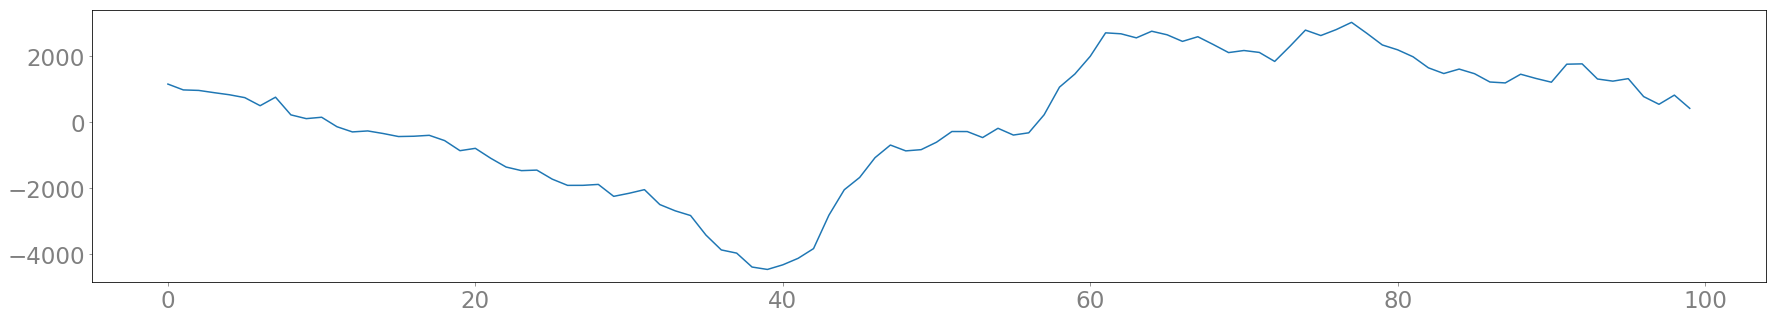

In [7]:
plot(sample[73000:73100])

In [8]:
coarse_classes, fine_classes = split_signal(sample)

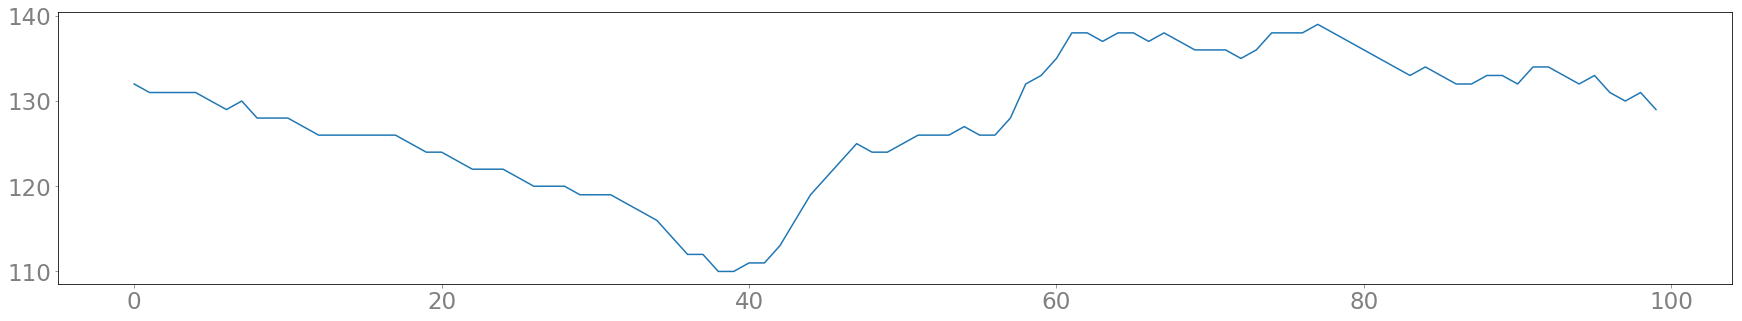

In [9]:
plot(coarse_classes[73000:73100])

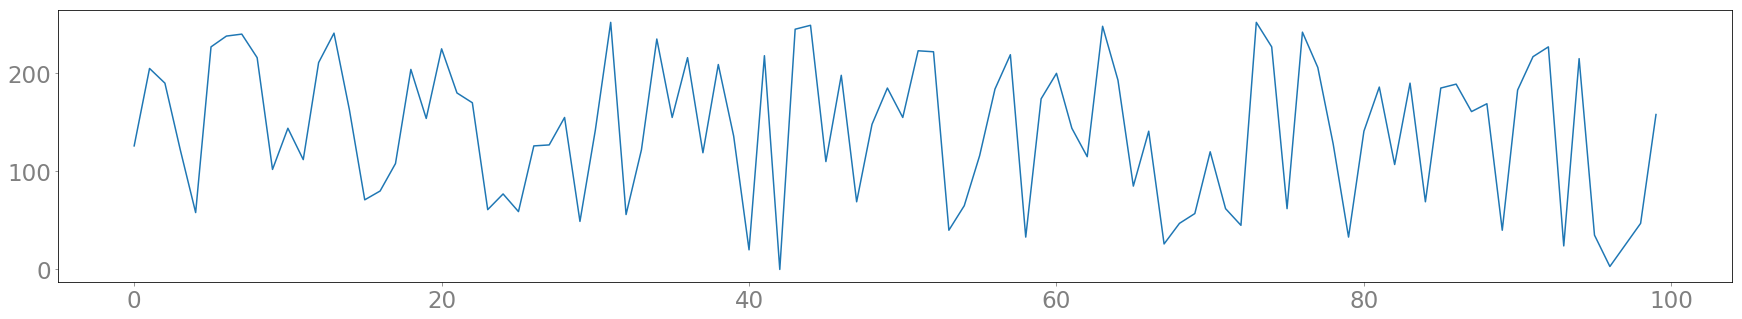

In [10]:
plot(fine_classes[73000:73100])

### Train Model

In [11]:
model = WaveRNN().cuda()

Trainable Parameters: 3.050 million


In [12]:
coarse_classes, fine_classes = split_signal(sample)

In [13]:
batch_size = 128 # 8gb gpu
coarse_classes = coarse_classes[:len(coarse_classes) // batch_size * batch_size]
fine_classes = fine_classes[:len(fine_classes) // batch_size * batch_size]
coarse_classes = np.reshape(coarse_classes, (batch_size, -1))
fine_classes = np.reshape(fine_classes, (batch_size, -1))

In [14]:
coarse_classes.shape

(128, 366411)

In [15]:
def train(model, optimizer, num_steps, batch_size, lr=1e-3, seq_len=960) :
    
    for p in optimizer.param_groups : p['lr'] = lr
    start = time.time()
    running_loss = 0
    
    for step in range(num_steps) :
        
        loss = 0
        hidden = model.init_hidden(batch_size)
        optimizer.zero_grad()
        rand_idx = np.random.randint(0, coarse_classes.shape[1] - seq_len - 1)
        
        x_coarse = coarse_classes[:, rand_idx:rand_idx + seq_len]
        x_coarse = torch.FloatTensor(x_coarse)
        x_coarse = x_coarse / 127.5 - 1.
        x_fine = fine_classes[:, rand_idx:rand_idx + seq_len]
        x_fine = torch.FloatTensor(x_fine)
        x_fine = x_fine / 127.5 - 1.
        
        y_coarse = coarse_classes[:, rand_idx + 1:rand_idx + seq_len + 1]
        y_coarse = torch.LongTensor(y_coarse)
        y_fine = fine_classes[:, rand_idx + 1: rand_idx + seq_len + 1]
        y_fine = torch.LongTensor(y_fine)
        
        for i in range(seq_len) :
            
            x_c_in = x_coarse[:, i:i + 1]
            x_f_in = x_fine[:, i:i + 1]
            x_input = torch.cat([x_c_in, x_f_in], dim=1)
            x_input = x_input.cuda()
            
            c_target = y_coarse[:, i].cuda()
            f_target = y_fine[:, i].cuda()
            
            
            current_coarse = c_target.float() / 127.5 - 1.
            current_coarse = current_coarse.unsqueeze(-1)
            
            out_coarse, out_fine, hidden = model(x_input, hidden, current_coarse)
            
            loss_coarse = F.cross_entropy(out_coarse, c_target)
            loss_fine = F.cross_entropy(out_fine, f_target)
            loss += (loss_coarse + loss_fine)
        
        running_loss += (loss.item() / seq_len)
        loss.backward()
        optimizer.step()
        
        elapsed = time_since(start)
        speed = (step + 1) / (time.time() - start)
        
        stream('Step: %i/%i --- Loss: %.3f --- %s --- @ %.1f batches/sec ',
              (step + 1, num_steps, running_loss / (step + 1), elapsed, speed))         

In [16]:
optimizer = optim.Adam(model.parameters())

In [ ]:
train(model, optimizer, num_steps=10000, batch_size=batch_size, lr=1e-3)

### Generation

In [ ]:
output, c, f = model.generate(sample_rate * 5)

In [ ]:
plot(output[:1000])

In [ ]:
plot(f[:100])

In [ ]:
def save_wav(y, filename, sample_rate) :
    y = np.clip(y, -2**15, 2**15 - 1)
    wavfile.write(filename, sample_rate, y.astype(np.int16))

In [ ]:
save_wav(output, f'outputs/{notebook_name}/model_output.wav', sample_rate)